In [249]:
import numpy as np
import torch
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import rmsprop, adam, SGD
from torch.nn.functional import one_hot
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

In [250]:
# Set the device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(device)

cpu


In [251]:
class LayerBlock(nn.Module):
    # Create a single layer block consisting of linear, optional batchnorm and leakyrelu
    def __init__(self, input_neurons, output_neurons, batch_norm=False, final_layer=False):
        super().__init__()
        
        self.inp = input_neurons
        self.out = output_neurons
        self.batch_norm = batch_norm
        self.final_layer = final_layer

        self.linear = nn.Linear(self.inp, self.out) 
        if self.batch_norm == True:
            self.bn = nn.BatchNorm1d(self.out) 
            
        self.act = nn.LeakyReLU() if self.final_layer == False else nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.linear(x)

        if self.batch_norm == True:
            x = self.bn(x)
            
        x = self.act(x)
        return x
        
class ModuleNet(nn.Module):
    # Will iterate over each module in module list and make full forward pass
    def __init__(self, module_list):
        super().__init__()
        self.mods = module_list
        # self.sig = nn.Sigmoid()

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        for i, l in enumerate(self.mods):
            x = l(x) 
        return x

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.labels = labels
        self.features = features
    
    def __len__(self):
        'Denotes the total number of samples'
        return np.shape(self.features)[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        x = self.features[index]
        y = self.labels[index]
        return x, y
    
class SimpleNet(nn.Module):

    def __init__(self, in_dim, out_dim, final_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.final_dim = final_dim

        self.linear_1 = nn.Linear(self.in_dim, self.out_dim)
        self.linear_2 = nn.Linear(self.out_dim, self.out_dim)
        self.final_layer = nn.Linear(self.out_dim, self.final_dim)

    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.sigmoid(self.final_layer(x))
        return x

In [252]:
# Features have already been pre-processed
train_x = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/scaled_unclipped_train_x.csv')
test_x = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/scaled_unclipped_test_x.csv')

# Labels
train_y = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/train_y.csv')
test_y = pd.read_csv('/Users/sum02dean/projects/wine_challenge/WINE/data/test_y.csv')

# Re-balance the labels
train_y['class'] = 0
train_y.loc[train_y['quality'] > 5, 'class'] = 1
train_x['labels'] = train_y['class']
train_x_bad = train_x[train_x['labels'] == 0]
train_x_good = train_x[train_x['labels'] == 1]
train_x_good_sample = train_x_good.sample(n=np.shape(train_x_bad)[0])


# Encode (OHE) labels
#train_ohe_y = one_hot(torch.tensor(train_y.values))
#test_ohe_y = one_hot(torch.tensor(test_y.values))


# Modify to binary classification
#y2 = np.where(train_y < 5, 0, 1)
#y3 = one_hot(torch.tensor(y2))

In [253]:
# Make the dataset balanced
train_x = pd.concat([train_x_good, train_x_bad], axis=0)
train_y = train_x.loc[:, 'labels']
train_ohe_y = one_hot(torch.tensor(train_y.values))
train_x = train_x.iloc[:, :-1]
print(train_ohe_y.shape)
print(train_x.shape)

torch.Size([5197, 2])
(5197, 13)


In [254]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True, 
          'drop_last':True}

# Train Dataloader
train_dataset = MyDataset(train_x.values, train_ohe_y)
train_dl = torch.utils.data.DataLoader(train_dataset, **params)

# Test Dataloader
# test_dataset = MyDataset(test_x.values, test_ohe_y)
# test_dl = torch.utils.data.DataLoader(test_dataset, **params)



In [255]:
# Specify input and output layers
n_input_neurons = 13
n_output_neurons = 2
hidden_layers = [50, 50]

# Initial input layer
# layers = [LayerBlock(n_input_neurons, hidden_layers[0], batch_norm=False)]

# Build the hidden layers
# for layer in range(0, len(hidden_layers)):
#     if layer == len(hidden_layers)-1:
#         layers.append(LayerBlock(hidden_layers[layer], n_output_neurons, final_layer=False))
#     else:
#         layers.append(LayerBlock(hidden_layers[layer], hidden_layers[layer +1], batch_norm=False))

# Convert to a Module list & build network
# modules = nn.ModuleList(layers[:])
#model = ModuleNet(module_list=modules)

model = SimpleNet(in_dim=n_input_neurons, out_dim=n_input_neurons, final_dim=n_output_neurons)
model = model.to(device)
display(model)

# Define the optimizers and loss function
loss_fn = BCEWithLogitsLoss()
optimizer = SGD(model.parameters(), lr=0.02, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min')


SimpleNet(
  (linear_1): Linear(in_features=13, out_features=13, bias=True)
  (linear_2): Linear(in_features=13, out_features=13, bias=True)
  (final_layer): Linear(in_features=13, out_features=2, bias=True)
)

In [256]:
# Set configurations
max_epochs = 2000
running_loss = 0

# Loop over epochs
model.train(True)
for epoch_index, epoch in enumerate(range(max_epochs)):
    
    # Training
    for i, data in enumerate(train_dl):
        
        # Get the inputs & labels
        batch, labels = data
        # Convert the data-types
        batch = batch.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # Transfer to device
        batch, labels = batch.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(batch)
        #outputs = outputs.unsqueeze(1)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

        

In [257]:
preds = []
targets = []
all_logits = []
# Predictions
for i, data in enumerate(train_dl):
    
    # Get the inputs & labels
    batch, labels = data

    # Convert the data-types
    batch = batch.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)
    
    # Transfer to device
    batch, labels = batch.to(device), labels.to(device)

    with torch.no_grad():
        logits = model(batch)
        predictions = torch.where(logits > 0.5, 1, 0)
        predictions = [np.argmax(x) for x in predictions.detach().numpy()]
        targs = [np.argmax(x) for x in labels.detach().numpy()]
        logits = [x[1] for x in logits.detach().numpy()]
        preds.append(predictions)
        targets.append(targs)
        all_logits.append(logits)

# Reformat the outputs
all_preds = [item for sublist in preds for item in sublist]
all_targs = [item for sublist in targets for item in sublist]
all_logits = [item for sublist in all_logits for item in sublist] 

In [258]:
df = pd.DataFrame({'predictions': all_preds, 'targets':all_targs})
df.loc[df['predictions'] == df['targets'], 'correct'] = 1
df.loc[df['predictions'] != df['targets'], 'correct'] = 0

# Report accuracy 
percentage_correct = (df['correct'].sum() / df.shape[0]) * 100
print(f'Accuracy: {percentage_correct:.02f} %')


Accuracy: 81.23 %


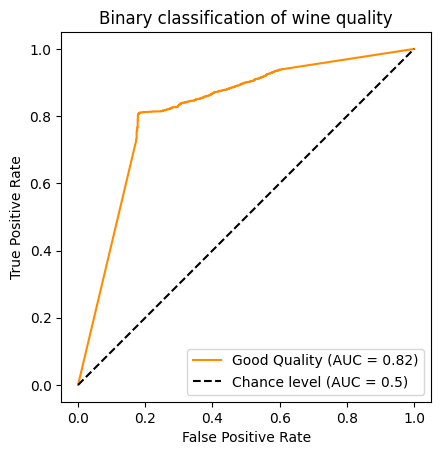

In [259]:
# Plot the ROC curve
roc_auc_score(all_targs, all_logits)
RocCurveDisplay.from_predictions(
    all_targs,
    all_logits,
    name="Good Quality",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary classification of wine quality")
plt.legend()
plt.show()